<a href="https://colab.research.google.com/github/Elvira-Zainulina/ml_MRI_age_prediction/blob/master/Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchio

     |████████████████████████████████| 71kB 5.5MB/s 
     |████████████████████████████████| 42.5MB 76kB/s 
  Created wheel for Python-Deprecated: filename=Python_Deprecated-1.1.0-py2.py3-none-any.whl size=3069 sha256=3002ff741bc1073342b2f8019b930ebd0cdbfaeed658c01c4d4978d098c613b7
  Stored in directory: /root/.cache/pip/wheels/b8/f1/81/2a12cf4208f219e3f023a6211a47165e74e50d534c6a3c3e64
Successfully built Python-Deprecated


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import numpy as np
import torch
from ml_utils.data import S500MRI_Dataset_simple
from ml_utils.uploading import load_data
from ml_utils.train_functions import predict, predict_VAE
from ml_utils.preprocessing import regroup_ages
from models import VAE_age
from models import S500MRI_clf, S500MRI_block, S500MRI_clf_block
from grad_cam import GradCam, ModelOutputs, ModelOutputs_VAE
# from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
from IPython.display import clear_output

In [0]:
path = r"drive/My Drive/Colab Notebooks/ml-project/data"

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Upload data from which the image will be chosen

In [0]:
X_test, y_test, g_test = load_data(os.path.join(path, 'test_dataset.npy'))

In [0]:
#target vector for 2-class classification
y_test_2 = regroup_ages(y_test)

In [0]:
test_data_4 = S500MRI_Dataset_simple(X_test, g_test, y_test)
test_data_2 = S500MRI_Dataset_simple(X_test, g_test, y_test,
                                     group_ages=True)

### Define models to be checked with Grad-Cam

#### VAE-C for $4$-class classification

In [0]:
vae_4 = torch.load(os.path.join(path, 'VAE_clf_s100.pt')).to(device)

In [0]:
grad_cam_vae_4 = GradCam(model=vae_4, target_layer_names=["12", "13", "15"], 
                         model_ouputs_class=ModelOutputs_VAE, device=device)

Get predictions of the model to choose the image.

In [50]:
pred_vae_4 = predict_VAE(vae_4, test_data_4, device=device)

#### VAE-C for $2$-class classification

In [0]:
vae_2 = torch.load(os.path.join(path, 'VAE_clf_2.pt')).to(device)

In [0]:
grad_cam_vae_2 = GradCam(model=vae_2, target_layer_names=["12", "13", "15"], 
                         model_ouputs_class=ModelOutputs_VAE, device=device)

Get predictions of the model to choose the image.

In [87]:
pred_vae_2 = predict_VAE(vae_2, test_data_2, device=device)

#### 3D CNN for $2$-class classification

In [0]:
cnn_2 = torch.load(os.path.join(path, 'clf_2__.pt')).to(device)

In [0]:
grad_cam_cnn_2 = GradCam(model=cnn_2, target_layer_names=["3"], 
                         model_ouputs_class=ModelOutputs, device=device)

Get predictions of the model to choose the image.

In [44]:
pred_cnn_2 = predict(cnn_2, test_data_2, device=device)

### Choose the images that were correctly and incorrectly predicted.

Consider cases for right and wrong predictions.

In [88]:
#choose right prediction
pos_ind_vae_4 = set(np.argwhere(pred_vae_4 == y_test).reshape(-1))
pos_ind_vae_2 = set(np.argwhere(pred_vae_2 == y_test_2).reshape(-1))
pos_ind_cnn_2 = set(np.argwhere(pred_cnn_2 == y_test_2).reshape(-1))

pos_ind = pos_ind_vae_4.intersection(pos_ind_vae_2).intersection(pos_ind_cnn_2)
pos_ind = list(pos_ind)[1]
pos_ind

4

In [89]:
#choose wrong prediction
neg_ind_vae_4 = set(np.argwhere(pred_vae_4 != y_test).reshape(-1))
neg_ind_vae_2 = set(np.argwhere(pred_vae_2 != y_test_2).reshape(-1))
neg_ind_cnn_2 = set(np.argwhere(pred_cnn_2 != y_test_2).reshape(-1))

neg_ind = pos_ind_vae_4.intersection(neg_ind_vae_2).intersection(neg_ind_cnn_2)
neg_ind = list(neg_ind)[0]
neg_ind

97

### Get masks for chosen images for each model

Right predicted image

In [0]:
pos_img, pos_g, pos_age = test_data[pos_ind]

In [0]:
#VAE-C for 4-class classification
pos_vae_4_mask = grad_cam_vae_4(pos_img.unsqueeze(0), pos_g)

#VAE-C for 2-class classification
pos_vae_2_mask = grad_cam_vae_2(pos_img.unsqueeze(0), pos_g)

#3D CNN for 2-class classification
pos_cnn_mask = grad_cam_cnn_2(pos_img.unsqueeze(0), pos_g)

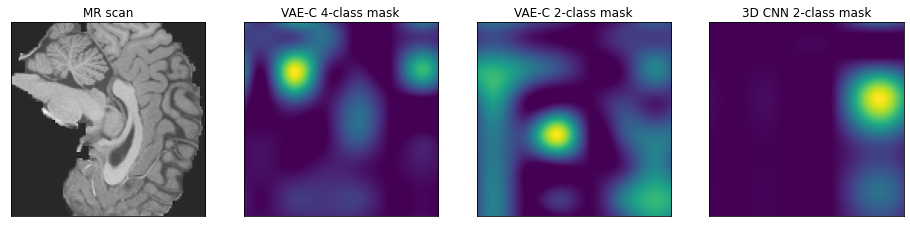

In [93]:
img = pos_img[0].numpy()

# for i in range(img.shape[1]):
#     clear_output(wait=True)
i = 64
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 5))
ax1.imshow(img[:, i], cmap='gray')
ax1.set_title('MR scan')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.imshow(pos_vae_4_mask[:, i])
ax2.set_title('VAE-C 4-class mask')
ax2.set_xticks([])
ax2.set_yticks([])
ax3.imshow(pos_vae_2_mask[:, i])
ax3.set_title('VAE-C 2-class mask')
ax3.set_xticks([])
ax3.set_yticks([])
ax4.imshow(pos_cnn_mask[:, i])
ax4.set_title('3D CNN 2-class mask')
ax4.set_xticks([])
ax4.set_yticks([])
plt.savefig(os.path.join(path, 'grad_cam_pos.png'))
plt.show()

Wrong predicted image

In [0]:
neg_img, neg_g, neg_age = test_data[neg_ind]

Masks for predicted label:

In [0]:
#VAE-C for 4-class classification
neg_vae_4_mask = grad_cam_vae_4(neg_img.unsqueeze(0), neg_g)

#VAE-C for 2-class classification
neg_vae_2_mask = grad_cam_vae_2(neg_img.unsqueeze(0), neg_g)

#3D CNN for 2-class classification
neg_cnn_mask = grad_cam_cnn_2(neg_img.unsqueeze(0), neg_g)

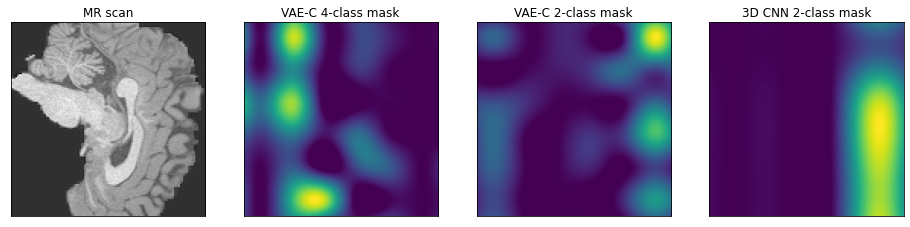

In [96]:
img = neg_img[0].numpy()

# for i in range(img.shape[1]):
#     clear_output(wait=True)
i = 64
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 5))
ax1.imshow(img[:, i], cmap='gray')
ax1.set_title('MR scan')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.imshow(neg_vae_4_mask[:, i])
ax2.set_title('VAE-C 4-class mask')
ax2.set_xticks([])
ax2.set_yticks([])
ax3.imshow(neg_vae_2_mask[:, i])
ax3.set_title('VAE-C 2-class mask')
ax3.set_xticks([])
ax3.set_yticks([])
ax4.imshow(neg_cnn_mask[:, i])
ax4.set_title('3D CNN 2-class mask')
ax4.set_xticks([])
ax4.set_yticks([])
plt.savefig(os.path.join(path, 'grad_cam_neg_pred.png'))
plt.show()

Masks for true label:

In [0]:
#VAE-C for 4-class classification
neg_vae_4_mask = grad_cam_vae_4(neg_img.unsqueeze(0), neg_g, index=neg_age)

#VAE-C for 2-class classification
neg_vae_2_mask = grad_cam_vae_2(neg_img.unsqueeze(0), neg_g, 
                                index=0 if neg_age < 2 else 1)

#3D CNN for 2-class classification
neg_cnn_mask = grad_cam_cnn_2(neg_img.unsqueeze(0), neg_g, 
                              index=0 if neg_age < 2 else 1)

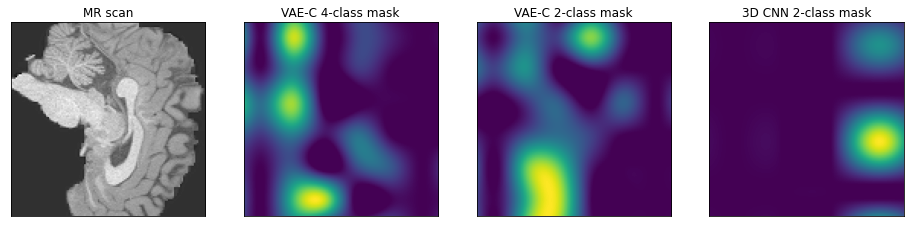

In [99]:
img = neg_img[0].numpy()

# for i in range(img.shape[1]):
#     clear_output(wait=True)
i = 64
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 5))
ax1.imshow(img[:, i], cmap='gray')
ax1.set_title('MR scan')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.imshow(neg_vae_4_mask[:, i])
ax2.set_title('VAE-C 4-class mask')
ax2.set_xticks([])
ax2.set_yticks([])
ax3.imshow(neg_vae_2_mask[:, i])
ax3.set_title('VAE-C 2-class mask')
ax3.set_xticks([])
ax3.set_yticks([])
ax4.imshow(neg_cnn_mask[:, i])
ax4.set_title('3D CNN 2-class mask')
ax4.set_xticks([])
ax4.set_yticks([])
plt.savefig(os.path.join(path, 'grad_cam_neg_true.png'))
plt.show()

As it can be found from the results, 3D-CNN wrongly determines important areas of the MR scan. Therefore, this model can not be used for any predictions.

VAE-C for $2$-class classification is most likely underfitted.

VAE-C for $4$-class classification determines important areas well. But it is also should be trained more.

Also, these masks revealed poorly performed preprocessing, it should be done more accurately.

